# Robust Journey Planner
This notebook describes the general path we have followed in order to convert raw data into a meaningful journey planner. The most important aspect of our developed planner is its robustness given that after exhaustive delay analysis based on historical data, every trip is associated with a probility. The system can be tested thanks to a validation method and the results can be visualied thanks to a curated interface. The purpose of this notebook is just to guide the reader in our learning and development process but there are links to more specific notebooks where all the details can be found. There are several parts to take into consideration:
*   **[Initial Setup](#initial)** — import libraries and explain tools that will be used
*   **[Public Transport Network](#network)**  — define network structure and connections timetable.
*   **[Probabilistic Model](#probability)** — analyse delay for associating every connection with an uncertainty rsk.
*   **[Route Planner Algorithm](#algorithm)**  — to apply a function to each element.
*   **[User Interface](#interface)** — design interface with desired trip as input and connection alternatives as output
*   **[Validation Method](#validation)** — test the developed system for checking its proper funtioning.

<a id = 'initial'></a>
## 1.Initial Setup

We use Spark, HDFS, pandas, bokeh...

In [7]:
import pandas as pd
import numpy as np
import math

In [4]:
from hdfs3 import HDFileSystem
hdfs = HDFileSystem(host='hdfs://iccluster044.iccluster.epfl.ch', port=8020, user='ebouille')
def read_csv(path, parts=None, **kwargs):
    dfs = []
    file_paths = [file_path for file_path in hdfs.ls(path) if file_path.endswith('.csv')]
    if parts:
        file_paths = file_paths[:parts]
    for file_path in file_paths:
        with hdfs.open(file_path) as file:
            dfs.append(pd.read_csv(file, **kwargs))
    return pd.concat(dfs)


<a id = 'network'></a>
## 2. Public Transport Network


Our project is based on the data published on  [ Open Data Platform Mobility Switzerland](https://opentransportdata.swiss/en/) This platform provides with scheduled timetables and actual historical data of several public trasnport services in Switzerland. In this section, we explain which data is actually relevant for our purposes and how we can model the public transport system

### 2.1 Zurich stations

We will be focusing on **Zurich** region, so we only take into account transport stops that are within 15-km of Zurich, taking <code>Zurich HB = [8.540192,47.378177]</code>  as reference point. The stations data [BFKOORD_GEO](https://opentransportdata.swiss/en/cookbook/hafas-rohdaten-format-hrdf/#Abgrenzung) is stored under HDFS <code>/data/sbb/stations/bfkoordgeo.csv</code> where latitude, longitude and height of every station is listed. We will compute the **Haversine distance** between Zurich HB and the rest of the stations for filtering out those that are outside the **15 km radius**. Please refer to [get_stations](./get_stations.ipynb) for more details. As a result, we obtain the following dataframe:


In [11]:
stations_info = read_csv('../data/zurich_stations_info.csv', parts=1)
stations_info.head()

,StationID,Longitude,Latitude,Height,Remark,Distance_from_Zurich
0,65,8.595545,47.409209,430,"Wallisellen, Glatt",5409.956757
1,66,8.595545,47.409209,430,"Wallisellen, Zentrum Glatt",5409.956757
2,176,8.521961,47.351679,0,Zimmerberg-Basistunnel,3250.669989
3,8502186,8.398942,47.393407,428,Dietikon Stoffelbach,10768.073180
4,8502187,8.377032,47.364740,502,Rudolfstetten Hofacker,12377.426177


### 2.2 What is a connection?

So after definiing the static nodes of our network (Zurich stations), we have to add the edges (the links) between each of them. Can we go from all possible stations to the rest of all possible stations? Is it worth it? How can we go? They are rather difficult questions to ask at first hand but it becomes easier after we perform some exploratory analysis on [SBB historical data](https://opentransportdata.swiss/en/dataset/istdaten) and we understand the difference between trip and connection: a **trip** makes reference to an ordered sequence of stops but they appear in different rows (one stop each) (having both arrival and departure times to/from this specific stop), where as a **connection** involves the departure time from one stop and the arrival time to a different one. Therefore, we conclude that connections are the edges of our network we are looking for, although the dataset is expressed in trips.

### 2.3 Walking connections

We start by looking at the easier connections: the walking ones. We assume it is sensible to connect **nearby stations** (<500 m of distance) by walking and we compute the required transfer time between each pair of stations. For more details please refere to the last part of the notebook [get_stations](./get_stations.ipynb). As a result, we obtain the following dataframe:

In [12]:
walking_connections = read_csv("../data/zurich_walking_connections.csv", parts=1)
walking_connections.head()

,ID1,Lon1,Lat1,H1,ID2,Lon2,Lat2,H2,Distance (m),Speed (m/min),Transfer time (sec)
0,65,8.595545,47.409209,430,65,8.595545,47.409209,430,0.000000,50.00,120.0
1,65,8.595545,47.409209,430,66,8.595545,47.409209,430,0.000000,50.00,120.0
2,65,8.595545,47.409209,430,8503129,8.591911,47.412717,431,493.557390,49.99,712.0
3,65,8.595545,47.409209,430,8587651,8.595545,47.409209,430,0.000000,50.00,120.0
4,65,8.595545,47.409209,430,8587655,8.592534,47.412720,431,463.889894,49.99,677.0


### 2.4 Transport connections timetable

There is a specific column in SBB dataset which refers to the **type of transport** for each trip. The most frequent ones are Train (Zug), Bus and Tram, but as mentioned beforet they are expressed in terms of trips, not in terms of connections. Therefore we need to transform the dataset so that we can link the different nodes (stations) of our network. Nonetheless, it is not a good idea to use the SBB historical for this purpose, given that if we select a random day and extract the connections of that specific day, there might be some **actual data missing**.

Having said that, we decide to use the timetable files available under HDFS, specially <code>stop_times.txt</code>, and we **build a schedule** for an "ideal" working day between 5h and 21h. Our network is thereby completed with the nodes (stations) and the edges (connections). After transforming the trips to connections in the notebook [get_timetable](./get_timetable.ipynb), we obtain the following dataframe:

In [ ]:
#id_connections = spark.read.orc('/user/datavirus/id_connections_new.orc').repartition(150, 'id')

## 3. Probabilistic Model

<a id = 'probability'></a>

## 4. Route Planner Algorithm

<a id = 'algorithm'></a>

## 5. User Interface

<a id = 'interface'></a>

## 6. Validation method

<a id = 'validation'></a>

## Distance Filter
First, we filter on only the stations in a 10km radius around Zürich. This allows for computation in "reasonable" time on the cluster.

In [4]:
def distance_squared(n1,e1, n2, e2):
    '''Calculates the euclidean distance between two points'''
    eucl_dist2 = ((n1-n2)*(n1-n2)+ (e1-e2)*(e1-e2))
    return eucl_dist2

In [5]:
coords_zurich = (683144.0, 248040.0) # X, Y  (E,N)
didok_path = '/user/rychener/stops.txt'

In [6]:
didok = spark.read.csv(didok_path, sep=';', header=True, inferSchema=True).select('Dst-Bezeichnung-offiziell','KOORDE','KOORDN')\
.withColumnRenamed('Dst-Bezeichnung-offiziell','station_name')

In [7]:
didok = didok.withColumn('dist2', distance_squared(coords_zurich[1], coords_zurich[0], didok.KOORDN, didok.KOORDE))

In [8]:
didok_10km = didok.filter(didok.dist2<=10000**2).persist()

In [9]:
didok_10km.count()

1250

In [10]:
stops_filter = didok_10km.select('station_name')
stops_filter.show(2)

+--------------------+
|        station_name|
+--------------------+
|  Dietikon, Hofacker|
|Dietikon, Birmens...|
+--------------------+
only showing top 2 rows



We can see there are 1250 stations aroud Zürich. By looking at the first two names, we can see that the filtering worked.

### Loading the Data

Now, we load the data and filter it in order to only keep the data of interest (in our radius).

In [11]:
swiss_data = spark.read.csv('/datasets/sbb/*/*/*.csv.bz2', header=True, sep=";")

In [12]:
istdaten = swiss_data.join(stops_filter, swiss_data.HALTESTELLEN_NAME == stops_filter.station_name, 'inner').persist()

In [17]:
istdaten.select('HALTESTELLEN_NAME').distinct().count()

988

We see that some datapoints from the didok were lost in our inner join. This is because didok does not only include stops, but also other operating points.

### Examine global distribution of delays

First, let's have a look at the global distribution of the delays.

First: get the delays

In [18]:
gd = istdaten.filter((istdaten.ANKUNFTSZEIT!='null')& (istdaten.AN_PROGNOSE!='null') & \
                     (istdaten.DURCHFAHRT_TF ==False) & (istdaten.ZUSATZFAHRT_TF==False))\
                                                    .select('PRODUKT_ID',
                                                          'LINIEN_ID',
                                                          'ANKUNFTSZEIT',
                                                          'AN_PROGNOSE',
                                                          'AN_PROGNOSE_STATUS')


In [19]:
from pyspark.sql.functions import unix_timestamp, round, log
gd = gd.withColumn('delay', round((unix_timestamp("AN_PROGNOSE", 'dd.MM.yyyy HH:mm:ss') - \
                               unix_timestamp("ANKUNFTSZEIT",'dd.MM.yyyy HH:mm'))/60)).persist()

In [20]:
gd.show(5)

+----------+---------+----------------+-------------------+------------------+-----+
|PRODUKT_ID|LINIEN_ID|    ANKUNFTSZEIT|        AN_PROGNOSE|AN_PROGNOSE_STATUS|delay|
+----------+---------+----------------+-------------------+------------------+-----+
|       Zug|       10|29.05.2019 21:50|29.05.2019 22:08:02|              REAL| 18.0|
|       Zug|     1007|29.05.2019 06:23|29.05.2019 06:25:20|              REAL|  2.0|
|       Zug|     1009|29.05.2019 07:23|29.05.2019 07:31:34|              REAL|  9.0|
|       Zug|     1011|29.05.2019 08:23|29.05.2019 08:24:02|              REAL|  1.0|
|       Zug|       12|29.05.2019 10:50|29.05.2019 10:51:59|              REAL|  2.0|
+----------+---------+----------------+-------------------+------------------+-----+
only showing top 5 rows



Second: Binning the data for plotting the histogram

In [ ]:
gd2 = gd.groupBy('delay').count().persist()
gd2.show(5)

In [ ]:
def plot_loghist(spark_df, title):
    df = spark_df.toPandas()
    plt.bar(df.delay,df['count'].apply(np.log))
    plt.title(title)
def plot_hist(spark_df, title):
    df = spark_df.toPandas()
    plt.bar(df.delay,df['count'])
    plt.title(title)

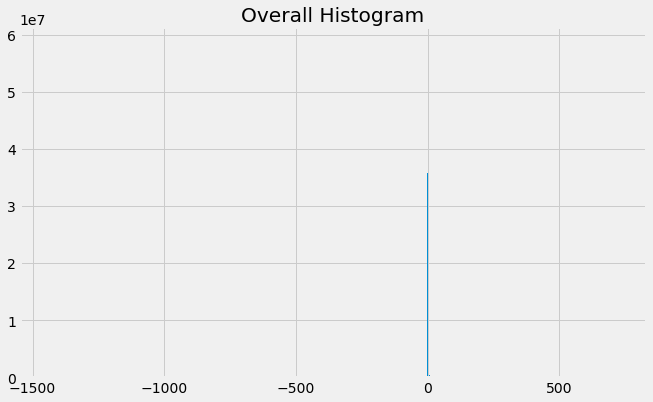

In [33]:
plot_hist(gd2, 'Overall Histogram')

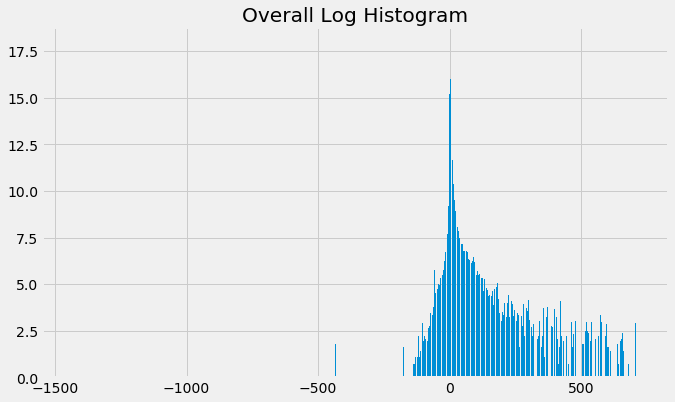

In [34]:
plot_loghist(gd2, 'Overall Log Histogram')

From the plot, it looks like this data may follow a lognormal distribution. This is also what other authors have found:
- *Modeling Passenger Train Delay Distributions  – Evidence and Implications* by Anna Bergström and Niclas A. Krüger
- *Stochastic Modelling of Train Delays and Delay Propagation in Stations* by Jianxin Yuan

We will now test this hypothesis using the Kolmogorov-Smirnov-Test:

#### Kolmogorov-Smirnov-Test

In [ ]:
from pyspark.mllib.stat import Statistics
def check_normality(spark_df, data_column):
    my_rdd = spark_df.rdd.map(lambda row: row[data_column])
    mu = my_rdd.mean()
    var = my_rdd.variance()
    norm_rdd = my_rdd.map(lambda v: (v-mu)/var)
    test_result = Statistics.kolmogorovSmirnovTest(norm_rdd, "norm")
    return test_result

In [26]:
gd = gd.filter(gd.delay>-100).withColumn('delay2', gd.delay+100)
log_check = gd.withColumn('log_delay', log('delay2'))
r = check_normality(log_check, 'log_delay')

In [27]:
print(r)

Kolmogorov-Smirnov test summary:
degrees of freedom = 0 
statistic = 0.7124155044726102 
pValue = 4.71847106942036E-8 
Very strong presumption against null hypothesis: Sample follows theoretical distribution.


The Global KS-Test is rejected. However, this does not imply that the finer-grain delays don't follow a lognormal distribution. We will now analyse the delay distributions for finer grain data, not on the global network:

## Predictor using trip and stop

This is the best estimator for the distribution, since it takes into account location, line and time (line & time information is contained in FAHRT_BEZEICHNER which characterises each trip).
We use Scipy to fit lognormal distributions to the data per trip and stop.

In [35]:
from pyspark.sql.functions import collect_list, when, unix_timestamp, round
from scipy.stats import lognorm, kstest

In [36]:
df = istdaten.filter((istdaten.DURCHFAHRT_TF ==False) & (istdaten.ZUSATZFAHRT_TF==False))
delays = df.select('FAHRT_BEZEICHNER',
                    'HALTESTELLEN_NAME',
                    'ANKUNFTSZEIT',
                    'AN_PROGNOSE',
                    'AN_PROGNOSE_STATUS')
delays = delays.withColumn('delay', when((delays.AN_PROGNOSE.isNull()) \
                                & (delays.ANKUNFTSZEIT.isNull()), None)\
                       .when((delays.AN_PROGNOSE.isNull()) \
                                & (delays.ANKUNFTSZEIT.isNotNull()), 0)\
                        .otherwise(round((unix_timestamp("AN_PROGNOSE", 'dd.MM.yyyy HH:mm:ss') - \
                                    unix_timestamp("ANKUNFTSZEIT",'dd.MM.yyyy HH:mm'))/60)))
delays = delays.where(delays.delay.isNotNull()).groupBy(['FAHRT_BEZEICHNER','HALTESTELLEN_NAME'])
delays = delays.agg(collect_list('delay').alias('delay_list'))
delays_fit_rdd = delays.rdd.map(lambda row:[row['FAHRT_BEZEICHNER'], row['HALTESTELLEN_NAME'],\
                                    [float(p) for p in lognorm.fit(row['delay_list'])]])
delays_fit = delays_fit_rdd.map(lambda row:(row[0],row[1],row[2])).toDF(['FAHRT_BEZEICHNER', 'HALTESTELLEN_NAME','fit_params'])
delays_fit_separated = delays_fit.select('FAHRT_BEZEICHNER', 'HALTESTELLEN_NAME', delays_fit["fit_params"].getItem(0).alias("shape"),\
                                         delays_fit["fit_params"].getItem(1).alias("mean"),\
                                         delays_fit["fit_params"].getItem(2).alias("std")).persist()
delays_fit_separated.show()

+----------------+-------------------+--------------------+--------------------+--------------------+
|FAHRT_BEZEICHNER|  HALTESTELLEN_NAME|               shape|                mean|                 std|
+----------------+-------------------+--------------------+--------------------+--------------------+
| 85:11:14021:001|   Zürich Wipkingen|   9.278022202009339|  0.9999999999999998|0.019951447869258464|
| 85:11:14027:002|   Zürich Flughafen|0.006614677657217521|  -94.99476702393153|   95.21537190196082|
|  85:11:1531:001|          Zürich HB|   0.715088946888826| -1.4519331285163273|   3.167638758453191|
| 85:11:18224:002|    Zürich Wiedikon| 0.47558117417007095| -0.3748313268055276|  1.8234320469954834|
| 85:11:18229:001|    Zürich Wiedikon|  0.5160836804695783| -0.2347240417263487|  1.7428950611749596|
| 85:11:18254:001|   Zürich Flughafen|  0.3081835496099491|  -2.224179497280597|  2.5041750914752003|
| 85:11:18255:002|    Zürich Oerlikon|  0.1221744533519207| -3.9834480156661174|  

The table above shows some obtained parameters from the lognorm fit. The function below calculates the fits for all stations in our radius.

In [ ]:
df = istdaten.filter((istdaten.DURCHFAHRT_TF ==False) & (istdaten.ZUSATZFAHRT_TF==False))
delays = df.select('FAHRT_BEZEICHNER',
                    'HALTESTELLEN_NAME',
                    'ANKUNFTSZEIT',
                    'AN_PROGNOSE',
                    'AN_PROGNOSE_STATUS')
delays = delays.withColumn('delay', when((delays.AN_PROGNOSE.isNull()) \
                                & (delays.ANKUNFTSZEIT.isNull()), None)\
                       .when((delays.AN_PROGNOSE.isNull()) \
                                & (delays.ANKUNFTSZEIT.isNotNull()), 0)\
                        .otherwise(round((unix_timestamp("AN_PROGNOSE", 'dd.MM.yyyy HH:mm:ss') - \
                                    unix_timestamp("ANKUNFTSZEIT",'dd.MM.yyyy HH:mm'))/60)))
delays = delays.where(delays.delay.isNotNull()).groupBy(['FAHRT_BEZEICHNER','HALTESTELLEN_NAME'])
delays = delays.agg(collect_list('delay').alias('delay_list'))
delays_fit_rdd = delays.rdd.map(lambda row:[row['FAHRT_BEZEICHNER'], row['HALTESTELLEN_NAME'],\
                                    [float(p) for p in lognorm.fit(row['delay_list'])]])
delays_fit = delays_fit_rdd.map(lambda row:(row[0],row[1],row[2])).toDF(['FAHRT_BEZEICHNER', 'HALTESTELLEN_NAME','fit_params'])
delays_fit_separated = delays_fit.select('FAHRT_BEZEICHNER', 'HALTESTELLEN_NAME', delays_fit["fit_params"].getItem(0).alias("shape"),\
                                         delays_fit["fit_params"].getItem(1).alias("mean"),\
                                         delays_fit["fit_params"].getItem(2).alias("std")).persist()
delays_fit_separated.write.csv('/user/rychener/delay_fit.csv')

Unfortunately, this model takes too long to precompute the csv on the cluster. We will therefore resort to a simpler model described below. For SBB, we would recommend to use the model above, but for our proof-of-concept we will use the simpler model.

## By LINIEN_TEXT and Station

As a simpler model, we will use line- and station-information. This model clearly lacks the time component. For example we would expect the delays to have some time-dependance, for example delays during rush-hour.

In [37]:
df = istdaten.filter((istdaten.DURCHFAHRT_TF ==False) & (istdaten.ZUSATZFAHRT_TF==False))
delays = df.select('LINIEN_TEXT',
                    'ANKUNFTSZEIT',
                    'AN_PROGNOSE',
                    'AN_PROGNOSE_STATUS',
                    'HALTESTELLEN_NAME')
delays = delays.withColumn('delay', when((delays.AN_PROGNOSE.isNull()) \
                                & (delays.ANKUNFTSZEIT.isNull()), None)\
                       .when((delays.AN_PROGNOSE.isNull()) \
                                & (delays.ANKUNFTSZEIT.isNotNull()), 0)\
                        .otherwise(round((unix_timestamp("AN_PROGNOSE", 'dd.MM.yyyy HH:mm:ss') - \
                                    unix_timestamp("ANKUNFTSZEIT",'dd.MM.yyyy HH:mm'))/60)))
delays = delays.where(delays.delay.isNotNull()).groupBy(['LINIEN_TEXT', 'HALTESTELLEN_NAME'])
delays = delays.agg(collect_list('delay').alias('delay_list'))
delays_fit_rdd = delays.rdd.map(lambda row:[row['LINIEN_TEXT'], row['HALTESTELLEN_NAME'],\
                                    [float(p) for p in lognorm.fit(row['delay_list'])]])
delays_fit = delays_fit_rdd.map(lambda row:(row[0],row[1],row[2])).toDF(['LINIEN_TEXT','HALTESTELLEN_NAME','fit_params'])
delays_fit_separated = delays_fit.select('LINIEN_TEXT', 'HALTESTELLEN_NAME', delays_fit["fit_params"].getItem(0).alias("shape"),\
                                         delays_fit["fit_params"].getItem(1).alias("mean"),\
                                         delays_fit["fit_params"].getItem(2).alias("std")).persist()
delays_fit_separated.show()

+-----------+--------------------+--------------------+--------------------+------------------+
|LINIEN_TEXT|   HALTESTELLEN_NAME|               shape|                mean|               std|
+-----------+--------------------+--------------------+--------------------+------------------+
|         13|Zürich, Museum fü...|   4.291869672675899| -57.000000005905335|0.6048538325127093|
|         13| Zürich, Waidfussweg|0.031585268113606665|  -65.47953949004216| 66.48971557424716|
|         17|Zürich, Sonneggst...| 0.03769992924719766| -31.230724855541354| 32.12987751850089|
|        308|  Urdorf, Spitzacker| 0.06598289825054149| -27.390162438543058|28.445629010834907|
|          4|    Zürich, Sportweg| 0.01941806896282222|    -109.34745321311|110.56110318647046|
|         40| Zürich, Buhnstrasse|0.043695554383044594| -26.738371262971746| 27.84025777321743|
|         66| Zürich, Zwinglihaus| 0.06423582994838065|  -30.84435509520261| 31.86220535981053|
|        701|Zürich, Loorenstr...| 0.098

In [38]:
delays_fit_separated.count()

3766

In [39]:
# the number of fits is reasonable to transfer to pandas
pandas_df = delays_fit_separated.toPandas()
pandas_df.head()

,LINIEN_TEXT,HALTESTELLEN_NAME,shape,mean,std
0,13,"Zürich, Museum für Gestaltung",4.291870,-57.000000,0.604854
1,13,"Zürich, Waidfussweg",0.031585,-65.479539,66.489716
2,17,"Zürich, Sonneggstrasse",0.037700,-31.230725,32.129878
3,308,"Urdorf, Spitzacker",0.065983,-27.390162,28.445629
4,4,"Zürich, Sportweg",0.019418,-109.347453,110.561103


In [40]:
pandas_df.to_csv('./data/params_by_stop_line.csv')

## Calculating a default value

We need to calculate a default value, in case the stop-line combination is not present in our delays dataframe. For this, we use a simple averaging of the cdfs.

In [ ]:
points = [i for i in range(60+1)]
def get_list_bins(s,loc,scale):
    cdfvals = lognorm.cdf(points, s, loc=loc, scale=scale).tolist()
    cdfvals.append(1)
    cdfvals_shifted = [0]
    cdfvals_shifted.extend(cdfvals[:-1])
    binvals = (np.array(cdfvals)-np.array(cdfvals_shifted))
    return binvals

In [ ]:
n= 0
accumulator = get_list_bins(0.030893,-69.659120,70.691868)*0
delays_df = pd.read_csv('../params_by_stop_line.csv')
for i,r in delays_df.iterrows():
    accumulator += get_list_bins(r['shape'],r['mean'],r['std'])
    n += 1
accumulator /= n

In [ ]:
np.save('./default_delay', accumulator)

## Working with the data
Below, we give the functions used to predict the delay used in our algorithm.
We give 2 methods:

1) Keep the dataframe in memory all the time. This is feasible in our case since it is not too long (~3600, see above). If we would use the more complex method, this would be impossible

2) Load the dataframe each time by chunks. This needs less memory, but is slower.

This memory-speed tradeoff will have to be reexamined for the bigger dataset and more complex delay estimation, but in our case method 1 works fine.<br>
Functions for using both methods are given.

In [41]:
DATA_PATH = './data/'

In [42]:
# method 1: keeping the pandas df always in memory
delays_df = pd.read_csv(DATA_PATH+'params_by_stop_line.csv')
# expected delay
def get_expected_dealy(station_name, line_id):
    '''
    Expected delay time of line line_id at station station_name
    '''
    row = delays_df.loc[(delays_df.LINIEN_TEXT == line_id) & (delays_df.HALTESTELLEN_NAME==station_name)]
    if row.shape[0]>0:
        s = row['shape'].values[0]
        loc = row['mean'].values[0]
        scale = row['std'].values[0]
        mean = stats.lognorm.mean(s, loc=loc, scale=scale)
        return mean
    else:
        return 0 # average expected delay over dataset is 0, congrats SBB ;)
    
# probability for delay
def get_delay_probability(station_name, line_id, delay):
    '''
    Probability that delay of line line_id at station station_name is smaller than delay in minutes
    '''
    row = delays_df.loc[(delays_df.LINIEN_TEXT == line_id) & (delays_df.HALTESTELLEN_NAME==station_name)]
    if row.shape[0]>0:
        # cdf parameters present, calcualte cdf value
        s = row['shape'].values[0]
        loc = row['mean'].values[0]
        scale = row['std'].values[0]
        return stats.lognorm.cdf(delay, s, loc=loc, scale=scale)
    else:
        # not present, resort to default
        binvals = np.load(DATA_PATH+'default_delay.npy')
        if delay>60:
            return 1 - binvals[61]
        p = 0
        for i in range(int(delay+1)):
            p += binvals[i]
        return p

In [43]:
# method 2: iterating through the df
# expected delay
def get_expected_dealy2(station_name, line_id):
    '''
    Expected delay time of line line_id at station station_name
    '''
    iter_csv = pd.read_csv(DATA_PATH+'params_by_stop_line.csv', iterator=True, chunksize=1000)
    row = pd.concat([chunk.loc[(chunk.LINIEN_TEXT == line_id) & (chunk.HALTESTELLEN_NAME==station_name)]
                    for chunk in iter_csv])
    if row.shape[0]>0:
        s = row['shape'].values[0]
        loc = row['mean'].values[0]
        scale = row['std'].values[0]
        mean = stats.lognorm.mean(s, loc=loc, scale=scale)
        return mean
    else:
        return 0 # average expected delay over dataset is 0, congrats SBB ;)
    
# probability for delay
def get_delay_probability2(station_name, line_id, delay):
    '''
    Probability that delay of line line_id at station station_name is smaller than delay in minutes
    '''
    iter_csv = pd.read_csv(DATA_PATH+'params_by_stop_line.csv', iterator=True, chunksize=1000)
    row = pd.concat([chunk.loc[(chunk.LINIEN_TEXT == line_id) & (chunk.HALTESTELLEN_NAME==station_name)]
                    for chunk in iter_csv])
    if row.shape[0]>0:
        # cdf parameters present, calcualte cdf value
        s = row['shape'].values[0]
        loc = row['mean'].values[0]
        scale = row['std'].values[0]
        return stats.lognorm.cdf(delay, s, loc=loc, scale=scale)
    else:
        # not present, resort to default
        binvals = np.load(DATA_PATH+'default_delay.npy')
        if delay>60:
            return 1 - binvals[61]
        p = 0
        for i in range(int(delay+1)):
            p += binvals[i]
        return p

In [45]:
from scipy import stats

In [46]:
# Example
print('Method 1, if present:')
print('N17 at Dübendorf, Breitibach:')
print('Probability that delay is less than 5 mins: {}'.format(get_delay_probability('Dübendorf, Breitibach', 'N17', 5)))
print('Expected Delay: {}'.format(get_expected_dealy('Dübendorf, Breitibach', 'N17')))
%timeit get_expected_dealy('Dübendorf, Breitibach', 'N17')
print('-'*60)
print('Method 1, if not present:')
print('N17 at wrongstation:')
print('Probability that delay is less than 5 mins: {}'.format(get_delay_probability('wrongstation', 'N17', 5)))
print('Expected Delay: {}'.format(get_expected_dealy('wrongstation', 'N17')))
%timeit get_expected_dealy('wrongstation', 'N17')
print('-'*60)
print('-'*60)
print('Method 2, if present:')
print('N17 at Dübendorf, Breitibach:')
print('Probability that delay is less than 5 mins: {}'.format(get_delay_probability2('Dübendorf, Breitibach', 'N17', 5)))
print('Expected Delay: {}'.format(get_expected_dealy2('Dübendorf, Breitibach', 'N17')))
%timeit get_expected_dealy2('Dübendorf, Breitibach', 'N17')
print('-'*60)
print('Method 2, if not present:')
print('N17 at wrongstation:')
print('Probability that delay is less than 5 mins: {}'.format(get_delay_probability2('wrongstation', 'N17', 5)))
print('Expected Delay: {}'.format(get_expected_dealy2('wrongstation', 'N17')))
%timeit get_expected_dealy2('wrongstation', 'N17')

Method 1, if present:
N17 at Dübendorf, Breitibach:
Probability that delay is less than 5 mins: 0.9840615880337417
Expected Delay: 1.4469826842499653
2.22 ms ± 172 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
------------------------------------------------------------
Method 1, if not present:
N17 at wrongstation:
Probability that delay is less than 5 mins: 0.9148335912728518
Expected Delay: 0
1.99 ms ± 123 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
------------------------------------------------------------
------------------------------------------------------------
Method 2, if present:
N17 at Dübendorf, Breitibach:
Probability that delay is less than 5 mins: 0.9840615880337417
Expected Delay: 1.4469826842499653
28.4 ms ± 4.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
------------------------------------------------------------
Method 2, if not present:
N17 at wrongstation:
Probability that delay is less than 5 mins: 0.9148335912728518
Expe

They give the same result, which is reassuring.

## Hypothesis Testing
We will now again test our hypthesis (that the distribution folllows a lognorm distribution). This is done for the method of estimating the density for each station and line pair.

In [16]:
from pyspark.sql.functions import collect_list, when, unix_timestamp, round
from scipy import stats

In [17]:
significance_level = 0.95
def test_lognorm(data):
    d = [i for i in data if i>=0]
    if not d:
        return 0
    loc, scale = stats.expon.fit(d)
    D,p = kstest(d, 'expon', [loc, scale])
    return int(p<(1-significance_level))

In [18]:
df = istdaten.filter((istdaten.DURCHFAHRT_TF ==False) & (istdaten.ZUSATZFAHRT_TF==False))
delays = df.select('LINIEN_TEXT',
                    'ANKUNFTSZEIT',
                    'AN_PROGNOSE',
                    'AN_PROGNOSE_STATUS',
                    'HALTESTELLEN_NAME')
delays = delays.withColumn('delay', when((delays.AN_PROGNOSE.isNull()) \
                                & (delays.ANKUNFTSZEIT.isNull()), None)\
                       .when((delays.AN_PROGNOSE.isNull()) \
                                & (delays.ANKUNFTSZEIT.isNotNull()), 0)\
                        .otherwise((unix_timestamp("AN_PROGNOSE", 'dd.MM.yyyy HH:mm:ss') - \
                                    unix_timestamp("ANKUNFTSZEIT",'dd.MM.yyyy HH:mm'))/60))
delays = delays.where(delays.delay.isNotNull()).groupBy(['LINIEN_TEXT', 'HALTESTELLEN_NAME'])
delays = delays.agg(collect_list('delay').alias('delay_list'))
delays_fit_rdd = delays.rdd.map(lambda row:[row['LINIEN_TEXT'], row['HALTESTELLEN_NAME'], 
                                            test_lognorm(row['delay_list'])])
delays_fit = delays_fit_rdd.map(lambda row:(row[0],row[1], row[2])).toDF(['LINIEN_TEXT', 'HALTESTELLEN_NAME','test_fail'])
delays_fit.agg({"test_fail": "avg"}).show()

+------------------+
|    avg(test_fail)|
+------------------+
|0.8688263409453001|
+------------------+



We can see that 87.5% of the fine-grain KS-tests are rejected. This is bad news! <br>
For a 95% significance level test, we would only expect 5% of the KS-tests to fail (if the null hypotheses were true for each station-line-combination). <br>
We will now look at one such fit:

In [19]:
df = istdaten.filter((istdaten.DURCHFAHRT_TF ==False) & (istdaten.ZUSATZFAHRT_TF==False))
delays = df.select('LINIEN_TEXT',
                    'ANKUNFTSZEIT',
                    'AN_PROGNOSE',
                    'AN_PROGNOSE_STATUS',
                    'HALTESTELLEN_NAME')
delays = delays.withColumn('delay', when((delays.AN_PROGNOSE.isNull()) \
                                & (delays.ANKUNFTSZEIT.isNull()), None)\
                       .when((delays.AN_PROGNOSE.isNull()) \
                                & (delays.ANKUNFTSZEIT.isNotNull()), 0)\
                        .otherwise((unix_timestamp("AN_PROGNOSE", 'dd.MM.yyyy HH:mm:ss') - \
                                    unix_timestamp("ANKUNFTSZEIT",'dd.MM.yyyy HH:mm'))/60))
delays = delays.where((delays.delay.isNotNull()) & (delays.LINIEN_TEXT=='IR') & (delays.HALTESTELLEN_NAME=='Zürich Flughafen'))
delays.show(5)

+-----------+----------------+-------------------+------------------+-----------------+------------------+
|LINIEN_TEXT|    ANKUNFTSZEIT|        AN_PROGNOSE|AN_PROGNOSE_STATUS|HALTESTELLEN_NAME|             delay|
+-----------+----------------+-------------------+------------------+-----------------+------------------+
|         IR|29.05.2019 06:11|29.05.2019 06:13:36|              REAL| Zürich Flughafen|               2.6|
|         IR|31.05.2019 06:11|31.05.2019 06:11:58|              REAL| Zürich Flughafen|0.9666666666666667|
|         IR|24.05.2019 06:11|24.05.2019 06:12:09|              REAL| Zürich Flughafen|              1.15|
|         IR|23.05.2019 06:11|23.05.2019 06:11:30|              REAL| Zürich Flughafen|               0.5|
|         IR|28.05.2019 06:11|28.05.2019 06:11:59|              REAL| Zürich Flughafen|0.9833333333333333|
+-----------+----------------+-------------------+------------------+-----------------+------------------+
only showing top 5 rows



In [20]:
dp = delays.toPandas()

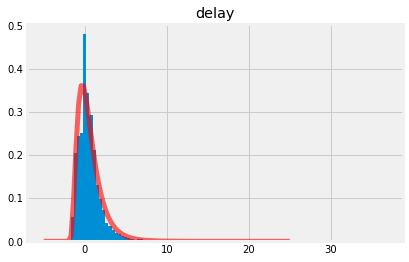

In [21]:
from scipy import stats
dp.hist('delay', bins=100, density=True)
f = stats.lognorm.fit(dp.delay)
x = np.linspace(-5, 25, 100)
plt.plot(x, lognorm.pdf(x, f[0], f[1], f[2]),'r-', lw=5, alpha=0.6, label='lognorm pdf')
plt.show()

In [22]:
stats.kstest(dp.delay, 'lognorm', f)

KstestResult(statistic=0.07310699299435197, pvalue=7.998470294173528e-43)

Upon examining the dealy histogram for one sample (IR in Zürich Airport), we can see that visually the fitted distribution fits quite well. We also tried with other distributions frequently mentionned in the literature (gamma, exponential, normal), but they all failed to produce better results. Also some more exotic distributions (skewed-normal, frechet, exponentially modified normal) were examined, but failed to improve the fit (measured by KS).